<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/SARIMA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/podobongbong/the_project.git

Cloning into 'the_project'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 27 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 447.59 KiB | 1.76 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

energy_data = pd.read_csv('/content/the_project/energy.csv')
energy_data.columns = ['year', 'city', 'district', 'type', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Filter total energy consumption ('주택용') and Busan data
energy_data = energy_data[(energy_data['type'] == '주택용') & (energy_data['city'] == '부산광역시')]

# Aggregate energy data by year and sum the monthly values for each year
monthly_columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
busan_energy = energy_data.groupby('year')[monthly_columns].sum().reset_index()

# Convert the monthly data into a single time series
busan_energy['resid_energy'] = busan_energy[monthly_columns].sum(axis=1)

# Set 'year' as the index
busan_energy.set_index('year', inplace=True)


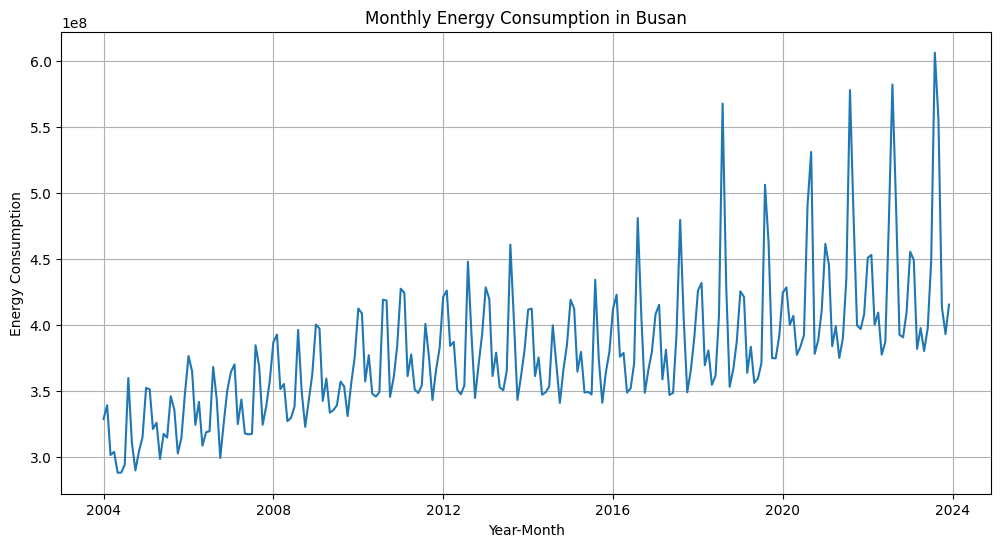

In [3]:
# prompt: flatten the busan_energy data, and draw a chart of monthly energy consumption in busan

# Flatten the data for plotting
busan_energy_flat = busan_energy[monthly_columns].stack().reset_index()
busan_energy_flat.columns = ['year', 'month', 'energy_consumption']

# Convert month to numerical representation
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
busan_energy_flat['month_num'] = busan_energy_flat['month'].map(month_mapping)

# Create a datetime index for plotting
busan_energy_flat['date'] = pd.to_datetime(busan_energy_flat.apply(lambda row: str(row['year']) + '-' + str(row['month_num']), axis=1))
busan_energy_flat.set_index('date', inplace=True)


# Plot the monthly energy consumption
plt.figure(figsize=(12, 6))
plt.plot(busan_energy_flat['energy_consumption'])
plt.xlabel('Year-Month')
plt.ylabel('Energy Consumption')
plt.title('Monthly Energy Consumption in Busan')
plt.grid(True)
plt.show()

In [5]:
# prompt: ARIMA Step1. stationary test

from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the energy consumption data
result = adfuller(busan_energy_flat['energy_consumption'])

# Print the results
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Interpret the results
if result[1] <= 0.05:
    print("The time series is likely stationary.")
else:
    print("The time series is likely non-stationary.")

ADF Statistic: -0.8731073651115295
p-value: 0.7966995147557543
Critical Values: {'1%': -3.4594900381360034, '5%': -2.8743581895178485, '10%': -2.573601605503697}
The time series is likely non-stationary.



ADF Statistic (Differenced Data): -10.332443007126447
p-value (Differenced Data): 2.8194668221464427e-18
Critical Values (Differenced Data): {'1%': -3.4594900381360034, '5%': -2.8743581895178485, '10%': -2.573601605503697}
The differenced time series is likely stationary.


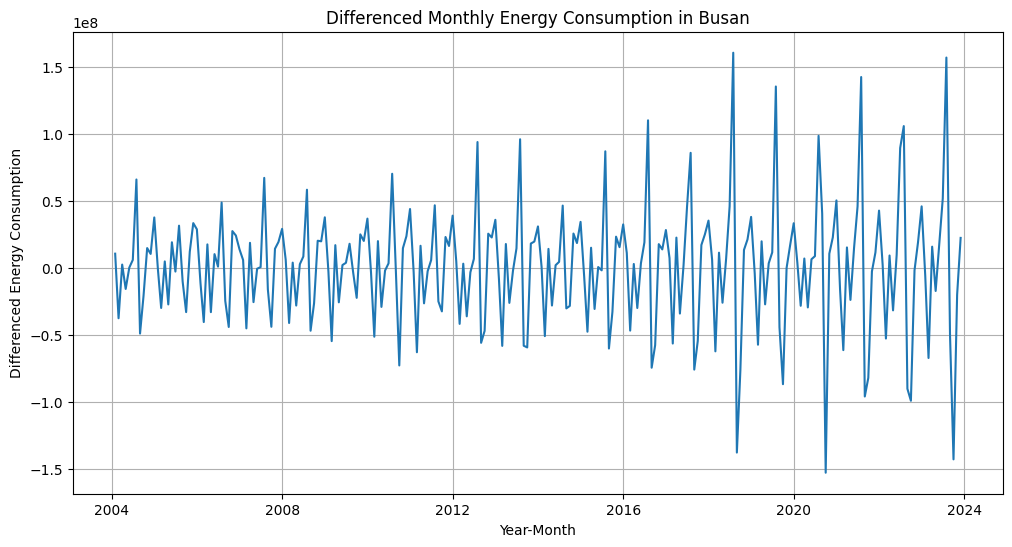

In [6]:
# prompt: # prompt: ARIMA Step1. data is non stationary, so apply differencing and re-do stationary test

# Apply differencing to make the time series stationary
busan_energy_flat['differenced_energy'] = busan_energy_flat['energy_consumption'].diff().dropna()

# Perform ADF test on the differenced data
result_diff = adfuller(busan_energy_flat['differenced_energy'])

# Print the results
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])
print('Critical Values (Differenced):', result_diff[4])

# Interpret the results
if result_diff[1] <= 0.05:
    print("The differenced time series is likely stationary.")
else:
    print("The differenced time series is likely non-stationary.")


# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(busan_energy_flat['differenced_energy'])
plt.xlabel('Year-Month')
plt.ylabel('Differenced Energy Consumption')
plt.title('Differenced Monthly Energy Consumption in Busan')
plt.grid(True)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used

Best AIC: 7826.625451530403
Best order: (2, 0, 2, 0, 1, 2)
Best seasonal order: (0, 1, 2, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optim

RMSE: 22333686.081993908
MAE: 15046416.377419105


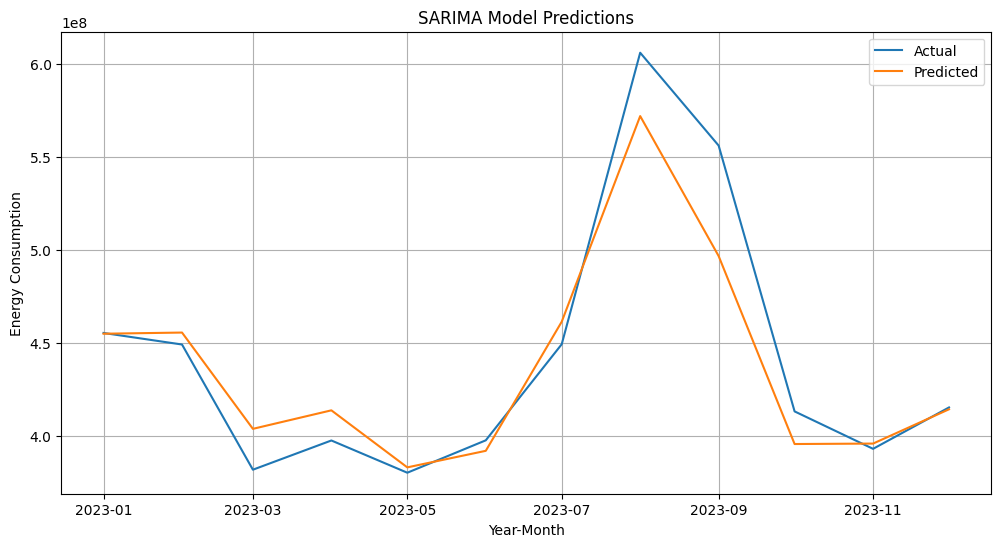

In [13]:
# prompt: ARIMA Step 3: Fit SARIMA and auto tune the model

from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# Split the data into training and testing sets
train_data = busan_energy_flat['energy_consumption'][:-12]
test_data = busan_energy_flat['energy_consumption'][-12:]

# Define the parameter ranges to search over
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
s = 12 # Seasonal period

# Generate all possible combinations of parameters
parameters = list(product(p, d, q, P, D, Q))

# Initialize variables for the best model and its performance
best_aic = float('inf')
best_order = None
best_seasonal_order = None

# Iterate through all parameter combinations
for order in parameters:
    try:
        model = SARIMAX(train_data, order=(order[0], order[1], order[2]), seasonal_order=(order[3], order[4], order[5], s))
        results = model.fit()

        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_seasonal_order = (order[3], order[4], order[5], s)

    except Exception as e:
        print(f"Error fitting model with order {order}: {e}")

print(f"Best AIC: {best_aic}")
print(f"Best order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Fit the SARIMA model with the best parameters
model = SARIMAX(train_data, order=(best_order[0], best_order[1], best_order[2]), seasonal_order=best_seasonal_order)
results = model.fit()

# Make predictions on the test set
predictions = results.predict(start=len(train_data), end=len(busan_energy_flat['energy_consumption']) - 1)

# Evaluate the model's performance
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mae = mean_absolute_error(test_data, predictions)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_data, label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Year-Month')
plt.ylabel('Energy Consumption')
plt.title('SARIMA Model Predictions')
plt.legend()
plt.grid(True)
plt.show()
